In [2]:
import torch
from torch.utils.data import DataLoader
from datasets.fungidataset import build_dataset
from torch import nn
IMAGEDIR = "/Users/koksziszdave/Downloads/fungi_images"
LABELDIR = "/Users/koksziszdave/Downloads/fungi_train_metadata.csv"

args = {
    "image_dir": IMAGEDIR,
    "labels_path": LABELDIR,
    "pre_load": False,
    "batch_size": 32
}

train_loader, valid_loader = build_dataset(args)

num_classes = 100


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np


class MultiTaskFungiNet(nn.Module):
    def __init__(self, num_classes, backbone_channels=64):
        """
        Multi-task CNN model for Fungi dataset.

        Args:
            num_classes (int): Number of fungal species classes.
            backbone_channels (int): Number of initial channels in the CNN backbone.
        """
        super(MultiTaskFungiNet, self).__init__()

        # CNN backbone
        self.encoder = nn.Sequential(
            nn.Conv2d(3, backbone_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(backbone_channels),
            nn.MaxPool2d(2),
            nn.Conv2d(backbone_channels, backbone_channels * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(backbone_channels * 2),
            nn.MaxPool2d(2),
            nn.Conv2d(backbone_channels * 2, backbone_channels * 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(backbone_channels * 4),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        # Flatten layer
        self.flatten = nn.Flatten()

        # Multi-task heads
        feature_dim = backbone_channels * 4
        self.sem_cls_head = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
        self.toxicity_head = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        features = self.encoder(x)
        features = self.flatten(features)

        sem_cls_output = self.sem_cls_head(features)
        toxicity_output = self.toxicity_head(features)

        return {"sem_cls": sem_cls_output, "toxicity": toxicity_output}


def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_cls = 0
    total_cls = 0
    for images, (class_ids, toxicities) in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        class_ids = class_ids.to(device)
        toxicities = toxicities.float().unsqueeze(1).to(device)

        # Forward pass
        outputs = model(images)
        loss_cls = criterion["classification"](outputs["sem_cls"], class_ids)
        loss_tox = criterion["toxicity"](outputs["toxicity"], toxicities)
        loss = loss_cls + loss_tox

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item()
        _, predicted_cls = torch.max(outputs["sem_cls"], 1)
        class_ids = torch.argmax(class_ids, dim=1)
        correct_cls += (predicted_cls == class_ids).sum().item()
        total_cls += class_ids.size(0)
        

    epoch_loss = running_loss / len(train_loader)
    accuracy_cls = correct_cls / total_cls
    return epoch_loss, accuracy_cls


def validate_epoch(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_cls = 0
    total_cls = 0
    with torch.no_grad():
        for images, (class_ids, toxicities)in tqdm(valid_loader, desc="Validation"):
            images = images.to(device)
            class_ids = class_ids.to(device)
            toxicities = toxicities.float().unsqueeze(1).to(device)

            # Forward pass
            outputs = model(images)
            loss_cls = criterion["classification"](outputs["sem_cls"], class_ids)
            loss_tox = criterion["toxicity"](outputs["toxicity"], toxicities)
            loss = loss_cls + loss_tox

            # Update metrics
            running_loss += loss.item()
            _, predicted_cls = torch.max(outputs["sem_cls"], 1)
            class_ids = torch.argmax(class_ids, dim=1)
            correct_cls += (predicted_cls == class_ids).sum().item()
            total_cls += class_ids.size(0)
            
    

    epoch_loss = running_loss / len(valid_loader)
    accuracy_cls = correct_cls / total_cls
    return epoch_loss, accuracy_cls


def train_model(model, train_loader, valid_loader, num_epochs, device):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

    criterion = {
        "classification": nn.CrossEntropyLoss(),
        "toxicity": nn.BCEWithLogitsLoss(),
    }

    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved.")

    print("Training complete. Best validation loss:", best_val_loss)


model = MultiTaskFungiNet(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(model, train_loader, valid_loader, num_epochs=20, device=device)

Epoch 1/20


Training: 100%|██████████| 645/645 [44:59<00:00,  4.19s/it]


Train Loss: 4.8220, Train Acc: 0.0338


Validation: 100%|██████████| 162/162 [04:57<00:00,  1.83s/it]


Val Loss: 4.5951, Val Acc: 0.0565
Model saved.
Epoch 2/20


Training: 100%|██████████| 645/645 [45:02<00:00,  4.19s/it]


Train Loss: 4.5382, Train Acc: 0.0601


Validation: 100%|██████████| 162/162 [04:43<00:00,  1.75s/it]


Val Loss: 4.3978, Val Acc: 0.0778
Model saved.
Epoch 3/20


Training: 100%|██████████| 645/645 [43:40<00:00,  4.06s/it]


Train Loss: 4.3748, Train Acc: 0.0760


Validation: 100%|██████████| 162/162 [04:44<00:00,  1.75s/it]


Val Loss: 4.2434, Val Acc: 0.0899
Model saved.
Epoch 4/20


Training: 100%|██████████| 645/645 [44:17<00:00,  4.12s/it]


Train Loss: 4.2341, Train Acc: 0.0915


Validation: 100%|██████████| 162/162 [04:47<00:00,  1.77s/it]


Val Loss: 4.1002, Val Acc: 0.1219
Model saved.
Epoch 5/20


Training: 100%|██████████| 645/645 [1:04:47<00:00,  6.03s/it]  


Train Loss: 4.1111, Train Acc: 0.1079


Validation: 100%|██████████| 162/162 [04:53<00:00,  1.81s/it]


Val Loss: 3.9817, Val Acc: 0.1353
Model saved.
Epoch 6/20


Training: 100%|██████████| 645/645 [45:35<00:00,  4.24s/it]


Train Loss: 3.9957, Train Acc: 0.1254


Validation: 100%|██████████| 162/162 [04:47<00:00,  1.77s/it]


Val Loss: 3.9933, Val Acc: 0.1331
Epoch 7/20


Training: 100%|██████████| 645/645 [44:05<00:00,  4.10s/it]


Train Loss: 3.9153, Train Acc: 0.1332


Validation: 100%|██████████| 162/162 [04:54<00:00,  1.82s/it]


Val Loss: 3.7790, Val Acc: 0.1574
Model saved.
Epoch 8/20


Training: 100%|██████████| 645/645 [49:15<00:00,  4.58s/it]


Train Loss: 3.8439, Train Acc: 0.1446


Validation: 100%|██████████| 162/162 [05:45<00:00,  2.13s/it]


Val Loss: 3.7128, Val Acc: 0.1729
Model saved.
Epoch 9/20


Training: 100%|██████████| 645/645 [46:46<00:00,  4.35s/it] 


Train Loss: 3.7778, Train Acc: 0.1515


Validation: 100%|██████████| 162/162 [05:24<00:00,  2.00s/it]


Val Loss: 3.6747, Val Acc: 0.1721
Model saved.
Epoch 10/20


Training: 100%|██████████| 645/645 [45:29<00:00,  4.23s/it]


Train Loss: 3.7246, Train Acc: 0.1592


Validation: 100%|██████████| 162/162 [04:46<00:00,  1.77s/it]


Val Loss: 3.6308, Val Acc: 0.1972
Model saved.
Epoch 11/20


Training: 100%|██████████| 645/645 [47:18<00:00,  4.40s/it]


Train Loss: 3.6570, Train Acc: 0.1688


Validation: 100%|██████████| 162/162 [05:48<00:00,  2.15s/it]


Val Loss: 3.5959, Val Acc: 0.1962
Model saved.
Epoch 12/20


Training: 100%|██████████| 645/645 [46:40<00:00,  4.34s/it]


Train Loss: 3.6124, Train Acc: 0.1811


Validation: 100%|██████████| 162/162 [05:00<00:00,  1.85s/it]


Val Loss: 3.5571, Val Acc: 0.2030
Model saved.
Epoch 13/20


Training: 100%|██████████| 645/645 [49:32<00:00,  4.61s/it]


Train Loss: 3.5636, Train Acc: 0.1910


Validation: 100%|██████████| 162/162 [05:57<00:00,  2.21s/it]


Val Loss: 3.4837, Val Acc: 0.2228
Model saved.
Epoch 14/20


Training: 100%|██████████| 645/645 [43:44<00:00,  4.07s/it]


Train Loss: 3.5173, Train Acc: 0.1962


Validation: 100%|██████████| 162/162 [04:48<00:00,  1.78s/it]


Val Loss: 3.4562, Val Acc: 0.2241
Model saved.
Epoch 15/20


Training: 100%|██████████| 645/645 [42:13<00:00,  3.93s/it]


Train Loss: 3.4686, Train Acc: 0.2051


Validation: 100%|██████████| 162/162 [04:48<00:00,  1.78s/it]


Val Loss: 3.4794, Val Acc: 0.2179
Epoch 16/20


Training: 100%|██████████| 645/645 [45:20<00:00,  4.22s/it]


Train Loss: 3.4305, Train Acc: 0.2112


Validation: 100%|██████████| 162/162 [05:11<00:00,  1.92s/it]


Val Loss: 3.3857, Val Acc: 0.2352
Model saved.
Epoch 17/20


Training: 100%|██████████| 645/645 [45:37<00:00,  4.24s/it]


Train Loss: 3.3875, Train Acc: 0.2199


Validation: 100%|██████████| 162/162 [05:14<00:00,  1.94s/it]


Val Loss: 3.3038, Val Acc: 0.2434
Model saved.
Epoch 18/20


Training: 100%|██████████| 645/645 [45:25<00:00,  4.23s/it]


Train Loss: 3.3510, Train Acc: 0.2295


Validation: 100%|██████████| 162/162 [04:59<00:00,  1.85s/it]


Val Loss: 3.3854, Val Acc: 0.2377
Epoch 19/20


Training: 100%|██████████| 645/645 [47:00<00:00,  4.37s/it]


Train Loss: 3.3166, Train Acc: 0.2313


Validation: 100%|██████████| 162/162 [05:24<00:00,  2.00s/it]


Val Loss: 3.2199, Val Acc: 0.2641
Model saved.
Epoch 20/20


Training: 100%|██████████| 645/645 [45:37<00:00,  4.24s/it]


Train Loss: 3.2740, Train Acc: 0.2399


Validation: 100%|██████████| 162/162 [05:09<00:00,  1.91s/it]

Val Loss: 3.2417, Val Acc: 0.2565
Training complete. Best validation loss: 3.2199200136484687


In [11]:
print(model)

MultiTaskFungiNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sem_cls_head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False

Evaluation: 100%|██████████| 162/162 [04:16<00:00,  1.58s/it]


Classification Metrics:

Confusion Matrix:
[[24 10  1 ...  0  0  0]
 [17 24  2 ...  0  1  0]
 [ 0  2  8 ...  0  0  1]
 ...
 [ 0  0  0 ... 15  0  0]
 [ 1  7  4 ...  0  0  0]
 [ 0  0  0 ...  0  0 25]]


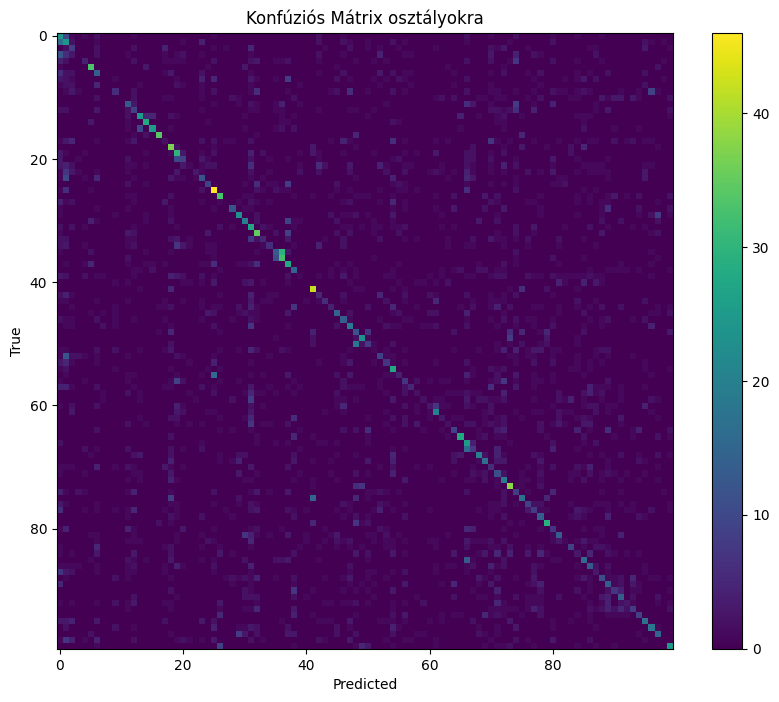


Toxicity Metrics:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4722
           1       0.73      0.06      0.10       430

    accuracy                           0.92      5152
   macro avg       0.82      0.53      0.53      5152
weighted avg       0.90      0.92      0.89      5152



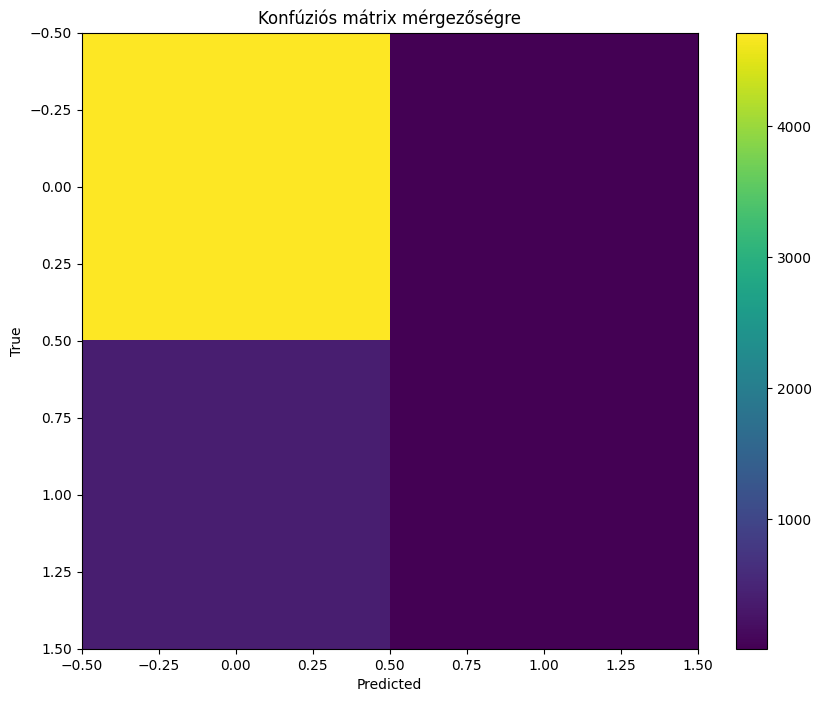

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
import torch
import numpy as np

def evaluate_model(model, data_loader, device):
    """
    Evaluates the model on the given data loader and prints classification metrics.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for evaluation data.
        device (torch.device): Device to perform computations on.
    """
    model.to(device)
    model.eval()

    all_targets_cls = []
    all_preds_cls = []
    all_targets_tox = []
    all_preds_tox = []

    with torch.no_grad():
        for images, (class_ids, toxicities) in tqdm(data_loader, desc="Evaluation"):
            if(images.shape[0]<32):
                continue
            images = images.to(device)
            class_ids = class_ids.to(device)
            

            # Forward pass
            outputs = model(images)

            # Collect predictions and ground truths for classification
            _, predicted_cls = torch.max(outputs["sem_cls"], 1)
            target_cls = torch.argmax(class_ids, dim=1)
            all_targets_cls.extend(target_cls.cpu().numpy())
            all_preds_cls.extend(predicted_cls.cpu().numpy())

            # Collect predictions and ground truths for toxicity regression
            predicted_tox = outputs["toxicity"].squeeze()
            predicted_tox= torch.sigmoid(predicted_tox).round().int()
            target_tox = toxicities.int()
            all_targets_tox.extend(target_tox.cpu().numpy())
            all_preds_tox.extend(predicted_tox.cpu().numpy())
            

    # Convert lists to numpy arrays
    all_targets_cls = np.array(all_targets_cls)
    all_preds_cls = np.array(all_preds_cls)
    all_targets_tox = np.array(all_targets_tox)
    all_preds_tox = np.array(all_preds_tox)

    # Classification Metrics
    print("\nClassification Metrics:")
    sem_repot=classification_report(all_targets_cls, all_preds_cls, zero_division=1)
    conf_matrix_cls = confusion_matrix(all_targets_cls, all_preds_cls)
    print("\nConfusion Matrix:")
    print(conf_matrix_cls)


    

   
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix_cls, cmap="viridis")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfúziós Mátrix osztályokra")
    plt.show()

    # Posisiion toxicity metrics
    print("\nToxicity Metrics:")
    print(classification_report(all_targets_tox, all_preds_tox, zero_division=1))
    conf_matrix_poi= confusion_matrix(all_targets_tox, all_preds_tox)
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix_poi, cmap="viridis")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfúziós mátrix mérgezőségre")
    plt.show()


   

    # Save metrics
    np.save("confusion_matrix_poi.npy", conf_matrix_poi)
    np.save("confusion_matrix_cls.npy", conf_matrix_cls)
    with open("classification_report.txt", "w") as f:
        f.write(classification_report(all_targets_cls, all_preds_cls, zero_division=1))
    with open("classification_report_poi.txt", "w") as f:
        f.write(classification_report(all_targets_tox, all_preds_tox, zero_division=1))
    

# Example call
evaluate_model(model, valid_loader, 'cpu')


In [29]:
#Save the full model for netron visualization
torch.save(model, 'fungi_model.pth')